In [1]:
def classwise_ece(y_true, y_prob, n_bins=10):
    n_classes = y_true.shape[1]
    ece = 0.0
    for c in range(n_classes):
        y_class = y_true[:, c]
        y_prob_class = y_prob[:, c]
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob_class, bins) - 1
        bin_sizes = np.bincount(bin_indices, minlength=n_bins)
        bin_probs = np.bincount(bin_indices, weights=y_prob_class, minlength=n_bins) / (bin_sizes + 1e-10)
        bin_accuracies = np.bincount(bin_indices, weights=y_class, minlength=n_bins) / (bin_sizes + 1e-10)
        ece_class = np.abs(bin_accuracies - bin_probs).dot(bin_sizes / y_class.shape[0])
        ece += ece_class
    ece /= n_classes
    return ece

In [2]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from tqdm import tqdm
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


TRAIN_SIZE = 3000
TEST_SIZE = 3000

mndata = MNIST('data')
images, labels = mndata.load_training()
images = np.array(images[:TRAIN_SIZE])
labels = np.array(labels[:TRAIN_SIZE])

test_images, test_labels = mndata.load_testing()
test_images = np.array(test_images[:TEST_SIZE])
test_labels = np.array(test_labels[:TEST_SIZE])

2023-02-17 22:44:06.836880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 22:44:06.937104: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 22:44:06.941687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 22:44:06.941703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
model = svm.SVC(probability=True)
model.fit(images, labels)

y_prob = model.predict_proba(test_images)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       271
           1       0.96      0.99      0.97       340
           2       0.92      0.92      0.92       313
           3       0.92      0.90      0.91       316
           4       0.92      0.93      0.93       318
           5       0.90      0.93      0.92       283
           6       0.95      0.91      0.93       272
           7       0.93      0.89      0.91       306
           8       0.91      0.88      0.89       286
           9       0.87      0.90      0.89       295

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



<AxesSubplot: >

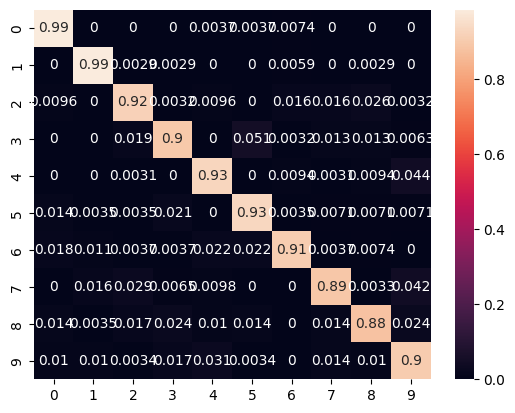

In [4]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print (classification_report(np.array(test_labels), np.argmax(y_prob, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob, axis=1), normalize="true"),annot=True)

In [5]:
accuracy = accuracy_score(np.array(test_labels), np.argmax(y_prob, axis=1))
print ("the accuracy of the model is: ", accuracy)

the accuracy of the model is:  0.923


In [6]:
ece_value = classwise_ece(np.eye(10)[test_labels], y_prob)
print("Expected Calibration Error:", ece_value)

Expected Calibration Error: 0.010463999714958965


# Cooperative models

In [7]:
model1 = svm.SVC(probability=True)
model1.fit(images[:len(images)//2], labels[:len(labels)//2])

y_prob1 = model1.predict_proba(test_images)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       271
           1       0.95      0.98      0.97       340
           2       0.91      0.88      0.89       313
           3       0.91      0.84      0.87       316
           4       0.91      0.88      0.89       318
           5       0.81      0.91      0.86       283
           6       0.93      0.89      0.91       272
           7       0.90      0.88      0.89       306
           8       0.88      0.81      0.85       286
           9       0.82      0.91      0.86       295

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



<AxesSubplot: >

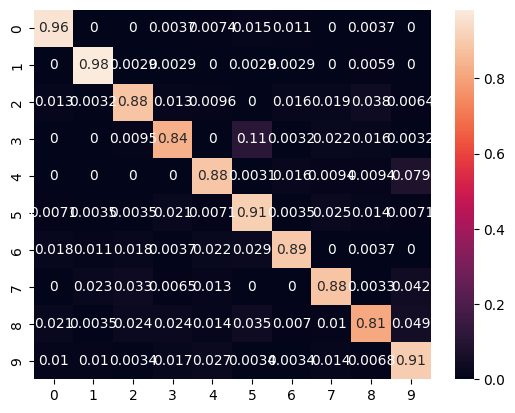

In [8]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print (classification_report(np.array(test_labels), np.argmax(y_prob1, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob1, axis=1), normalize="true"),annot=True)

In [9]:
model2 = svm.SVC(probability=True)
model2.fit(images[len(images)//2:], labels[len(labels)//2:])

y_prob2 = model2.predict_proba(test_images)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       271
           1       0.97      0.97      0.97       340
           2       0.90      0.90      0.90       313
           3       0.91      0.89      0.90       316
           4       0.88      0.93      0.91       318
           5       0.94      0.91      0.93       283
           6       0.93      0.91      0.92       272
           7       0.90      0.87      0.88       306
           8       0.87      0.85      0.86       286
           9       0.86      0.87      0.87       295

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



<AxesSubplot: >

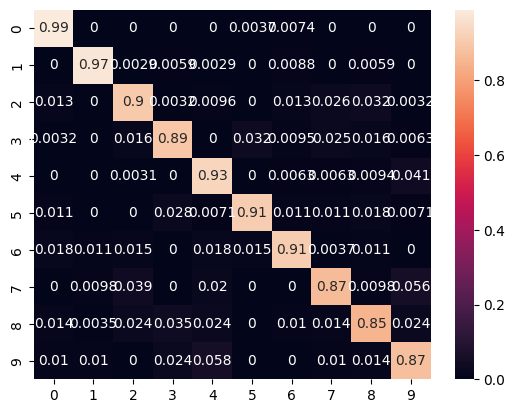

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print (classification_report(np.array(test_labels), np.argmax(y_prob2, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob2, axis=1), normalize="true"),annot=True)

### Resulting model

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       271
           1       0.97      0.98      0.97       340
           2       0.92      0.90      0.91       313
           3       0.91      0.87      0.89       316
           4       0.91      0.92      0.92       318
           5       0.88      0.92      0.90       283
           6       0.94      0.91      0.93       272
           7       0.91      0.88      0.90       306
           8       0.90      0.84      0.87       286
           9       0.85      0.91      0.88       295

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



<AxesSubplot: >

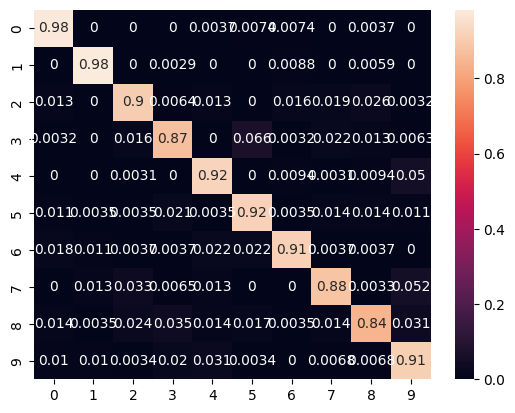

In [11]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print (classification_report(np.array(test_labels), np.argmax((y_prob1 + y_prob2)/2, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax((y_prob1 + y_prob2)/2, axis=1), normalize="true"),annot=True)

In [12]:
ece_value = classwise_ece(np.eye(10)[test_labels], (y_prob1 + y_prob2)/2)
print("Expected Calibration Error:", ece_value)

Expected Calibration Error: 0.01671044579360866


Testing for different lambda values

In [13]:

def lambda_tests():
    thetas = []
    accuracy_scores = []
    f1_mean_scores = []
    ece_values = []
    theta = 0
    while theta <= 1:
        thetas.append(theta)
        y_prob = theta * y_prob1 + (1 - theta) * y_prob2
        f1_scores = f1_score(np.array(test_labels), np.argmax(y_prob, axis=1), average=None)
        f1_mean_scores.append(np.mean(f1_scores))

        accuracy = accuracy_score(np.array(test_labels), np.argmax(y_prob, axis=1))
        accuracy_scores.append(accuracy)

        ece_value = classwise_ece(np.eye(10)[test_labels], y_prob)
        ece_values.append(ece_value)
        theta += 0.05

    return thetas, accuracy_scores, f1_mean_scores, ece_values

thetas, accuracy_scores, f1_mean_scores, ece_values = lambda_tests()


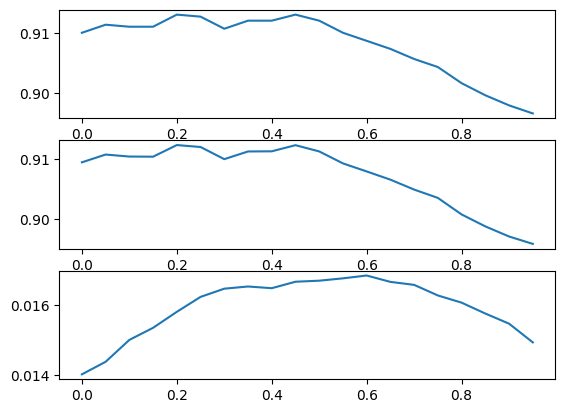

In [16]:
figure, axis = plt.subplots(3)

df = pd.DataFrame()
df["theta"] = thetas
df["f1_score"] = f1_mean_scores
df["accuracy_score"] = accuracy_scores
df["ece_value"] = ece_values

axis[0].plot(df["theta"], df["accuracy_score"])
axis[1].plot(df["theta"], df["f1_score"])
axis[2].plot(df["theta"], df["ece_value"])
plt.show()

In [19]:
print("the maximal value for the accuracy is: ", np.max(df["accuracy_score"]))
print("the maximal value for the f1-score is: ", np.max(df["f1_score"]))
print("the minimal value for the f1-score is: ", np.min(df["ece_value"]))

the maximal value for the accuracy is:  0.913
the maximal value for the f1-score is:  0.9123526689962048
the minimal value for the f1-score is:  0.014016258747239801


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e76c8840-118e-4c48-bc4e-42f2efb5350a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>